

---


# **COMP1801 - Machine Learning Coursework Python Notebook**

### Hitesh Taneja – 001406939


---



In [97]:
# Basic Libraries
import warnings  # Suppress warning messages
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import seaborn as sns  # Data visualization
import matplotlib.pyplot as plt  # Plotting library

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV  # Model training and hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Data preprocessing
from sklearn.compose import ColumnTransformer  # Preprocessing pipeline for mixed data types
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression  # Regression and classification models
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.metrics import (  # Model evaluation metrics
    mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
)
from xgboost import XGBRegressor
# Clustering Libraries
from sklearn.cluster import KMeans  # K-Means clustering
from sklearn.decomposition import PCA  # Dimensionality reduction for visualization

# SMOTE for Handling Class Imbalance
from imblearn.over_sampling import SMOTE  # Synthetic Minority Oversampling Technique
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline for imbalanced datasets


In [98]:
# Suppress warning messages for cleaner output
warnings.filterwarnings("ignore")

# Load the dataset into a DataFrame
df = pd.read_csv('COMP1801_Coursework_Dataset.csv')

# Inspect the dataset's size, data types, and summary statistics
print(df.head())  # Display the first 5 rows of the dataset
print(df.info())  # Show data types and non-null counts
print(df.describe())  # Provide summary statistics for numerical columns

   Lifespan partType microstructure  coolingRate  quenchTime  forgeTime  \
0   1469.17   Nozzle      equiGrain           13        3.84       6.47   
1   1793.64    Block    singleGrain           19        2.62       3.48   
2    700.60    Blade      equiGrain           28        0.76       1.34   
3   1082.10   Nozzle       colGrain            9        2.01       2.19   
4   1838.83    Blade       colGrain           16        4.13       3.87   

   HeatTreatTime  Nickel%  Iron%  Cobalt%  Chromium%  smallDefects  \
0          46.87    65.73  16.52    16.82       0.93            10   
1          44.70    54.22  35.38     6.14       4.26            19   
2           9.54    51.83  35.95     8.81       3.41            35   
3          20.29    57.03  23.33    16.86       2.78             0   
4          16.13    59.62  27.37    11.45       1.56            10   

   largeDefects  sliverDefects seedLocation    castType  
0             0              0       Bottom         Die  
1           

In [99]:
# Check for duplicate rows in the dataset
duplicates = df.duplicated().sum()  # Count duplicate rows
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [100]:
# Check for missing values in each column
missing_values = df.isnull().sum()  # Count missing values in each column
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
Lifespan          0
partType          0
microstructure    0
coolingRate       0
quenchTime        0
forgeTime         0
HeatTreatTime     0
Nickel%           0
Iron%             0
Cobalt%           0
Chromium%         0
smallDefects      0
largeDefects      0
sliverDefects     0
seedLocation      0
castType          0
dtype: int64


In [101]:
# Identify outliers in numerical features using the IQR method
numerical_features = ['forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'Cobalt%',
                      'Chromium%', 'smallDefects', 'largeDefects', 'sliverDefects',
                      'coolingRate', 'quenchTime', 'Lifespan']  # List of numerical features
categorical_features = ['partType', 'microstructure', 'seedLocation', 'castType']  # List of categorical features

outliers = {}  # Dictionary to store the number of outliers for each feature
for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)  # Calculate the first quartile
    Q3 = df[feature].quantile(0.75)  # Calculate the third quartile
    IQR = Q3 - Q1  # Calculate the interquartile range
    lower_bound = Q1 - 1.5 * IQR  # Calculate the lower bound
    upper_bound = Q3 + 1.5 * IQR  # Calculate the upper bound
    # Count the number of outliers outside the bounds
    outliers[feature] = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].shape[0]

print("\nNumber of outliers in each numerical feature:")
for feature, count in outliers.items():
    print(f"{feature}: {count}")  # Display the number of outliers for each feature


Number of outliers in each numerical feature:
forgeTime: 0
HeatTreatTime: 0
Nickel%: 0
Iron%: 0
Cobalt%: 0
Chromium%: 0
smallDefects: 3
largeDefects: 218
sliverDefects: 73
coolingRate: 0
quenchTime: 0
Lifespan: 0


In [102]:
# Check for inconsistent values in the 'Lifespan' feature (negative values)
negative_lifespan = df[df['Lifespan'] < 0]
print(f"\nNumber of negative values in Lifespan: {negative_lifespan.shape[0]}")


Number of negative values in Lifespan: 0


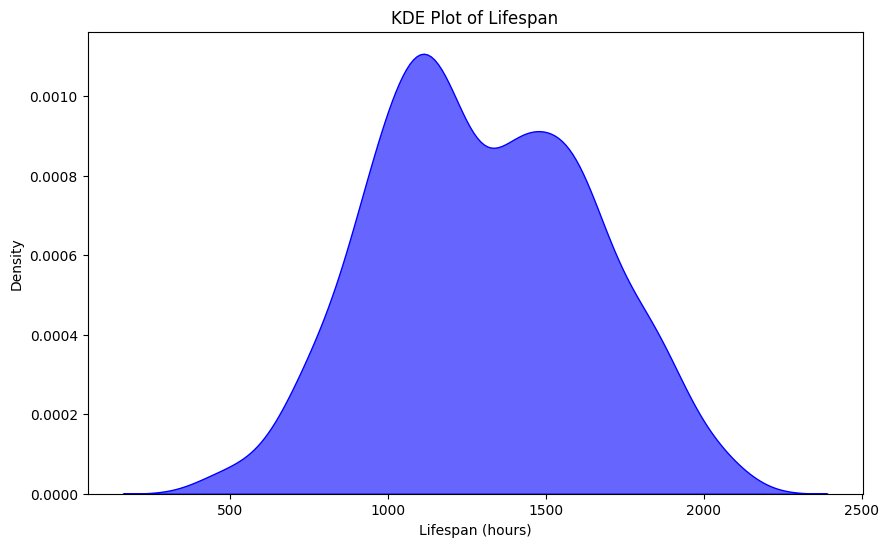

In [103]:
# Visualize the distribution of the target variable 'Lifespan'
plt.figure(figsize=(10, 6))  # Set the figure size
sns.kdeplot(df['Lifespan'], shade=True, color='blue', alpha=0.6)  # Plot the KDE for Lifespan
plt.title('KDE Plot of Lifespan')  # Add the title
plt.xlabel('Lifespan (hours)')  # Label the x-axis
plt.ylabel('Density')  # Label the y-axis
plt.show()

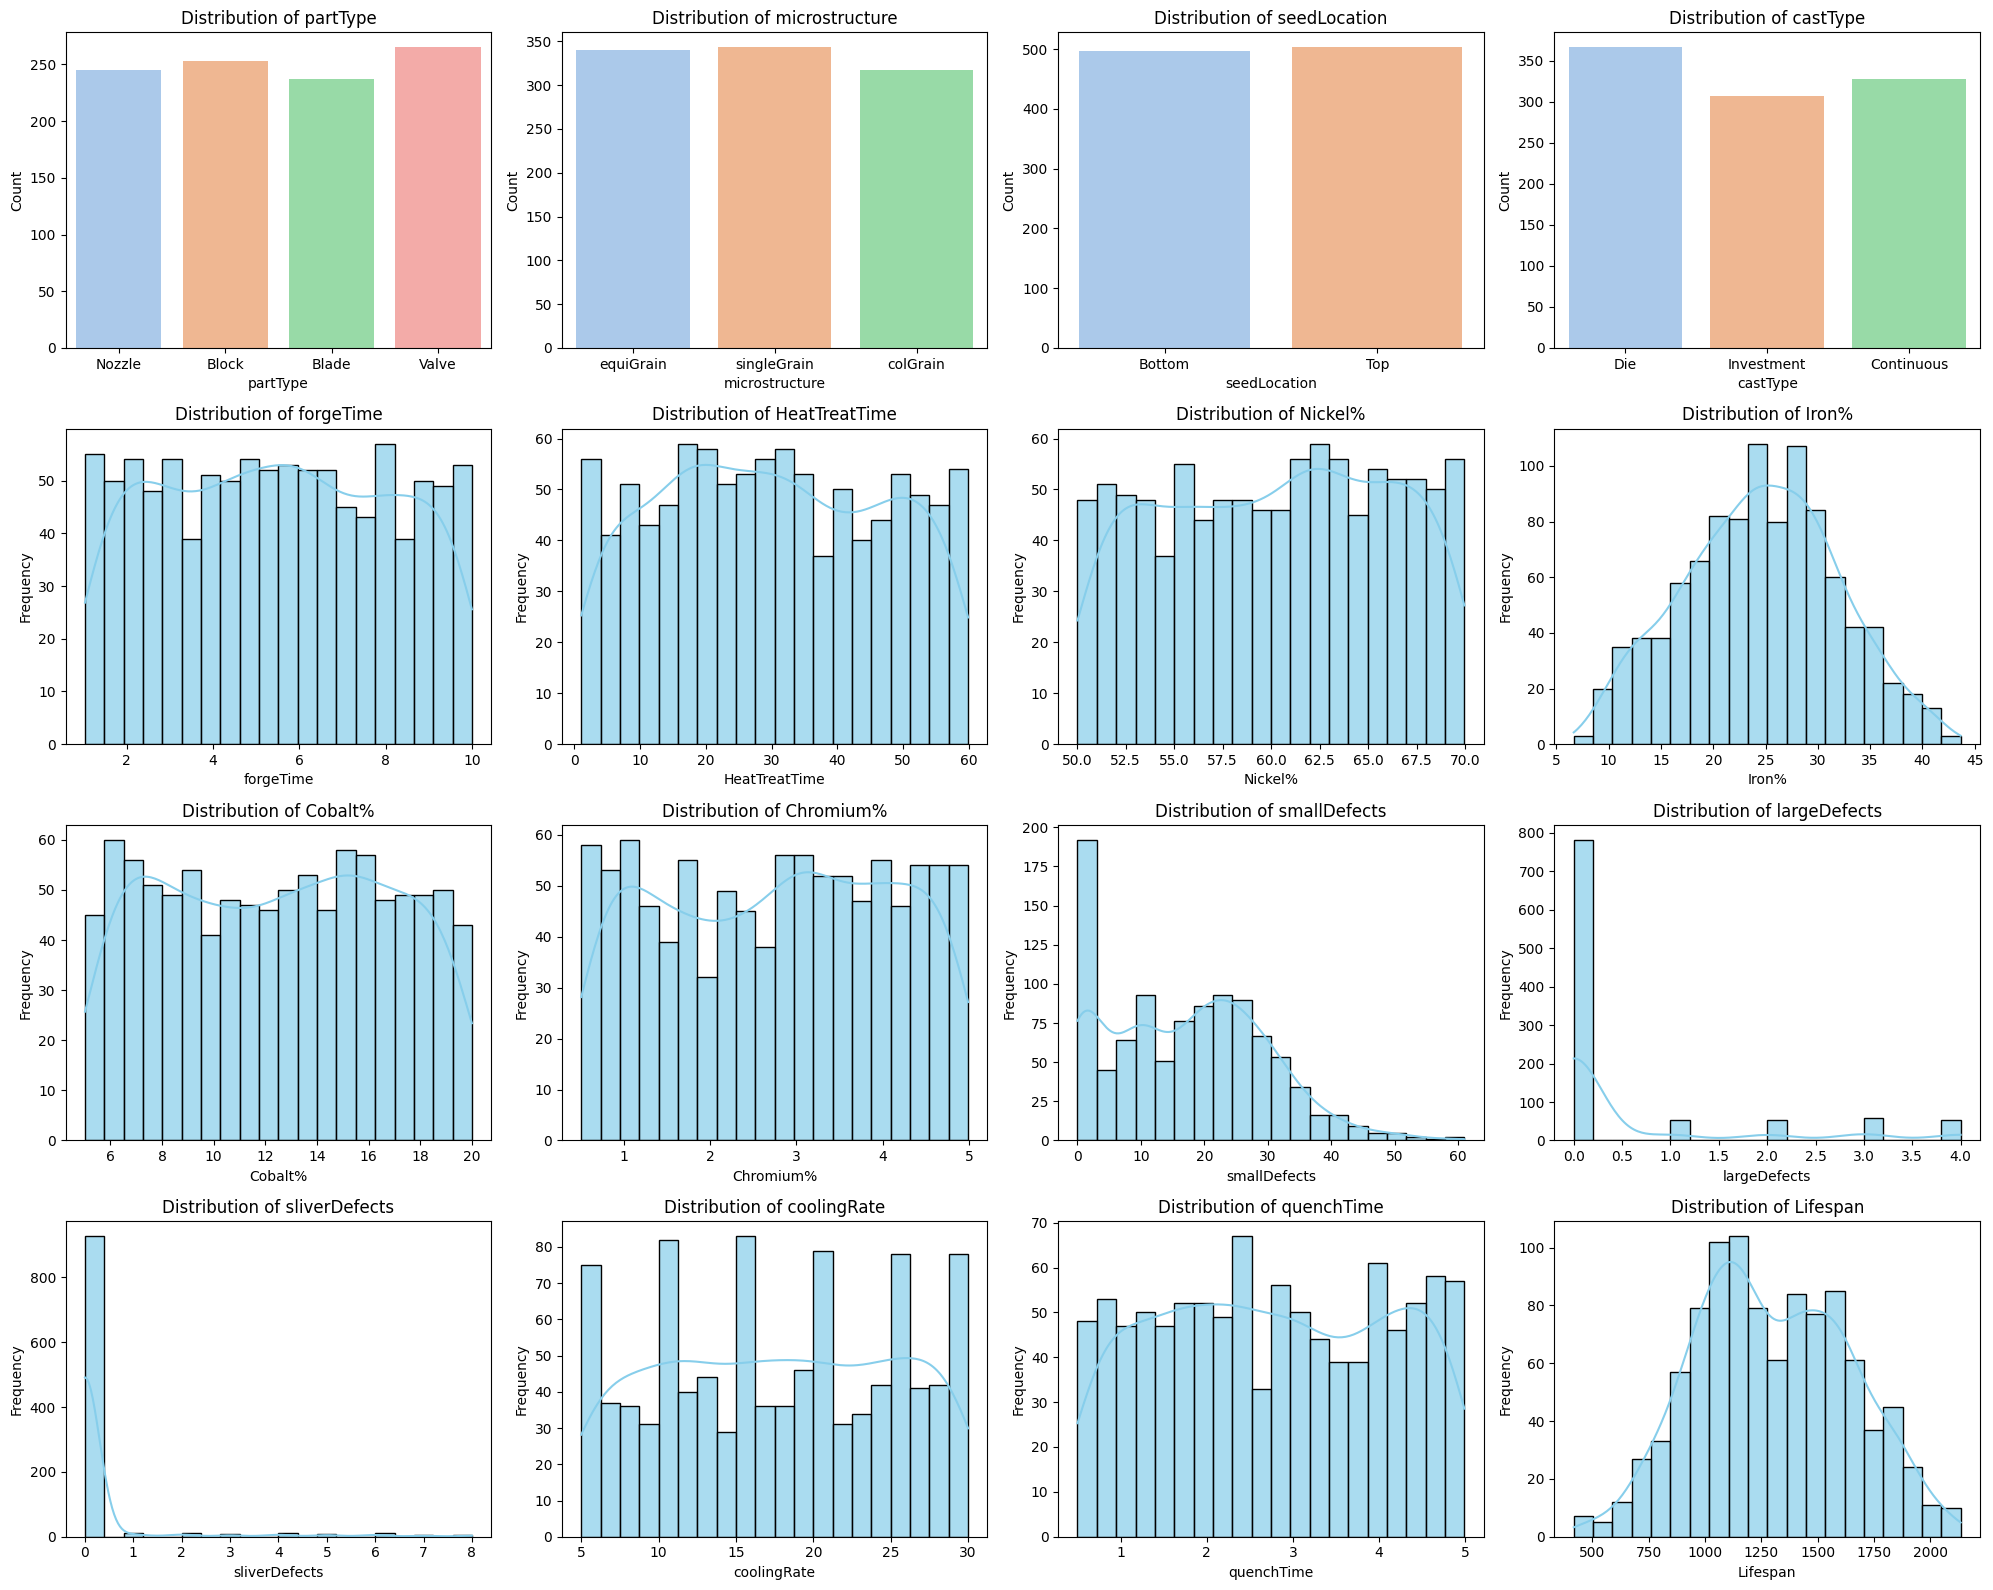

In [104]:
# Create a single figure for all categorical and numerical univariate analyses
fig, axes = plt.subplots(4, 4, figsize=(20, 16))  # Create subplots with 4x4 grid
axes = axes.flatten()  # Flatten the grid for easy iteration

# Plot for categorical features
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, palette='pastel', ax=axes[i])  # Create count plots
    axes[i].set_title(f'Distribution of {feature}')  # Add the title
    axes[i].set_xlabel(feature)  # Label the x-axis
    axes[i].set_ylabel('Count')  # Label the y-axis

# Plot for numerical features
for i, feature in enumerate(numerical_features, start=len(categorical_features)):
    sns.histplot(df[feature], bins=20, kde=True, color='skyblue', alpha=0.7, ax=axes[i])  # Create histograms
    axes[i].set_title(f'Distribution of {feature}')  # Add the title
    axes[i].set_xlabel(feature)  # Label the x-axis
    axes[i].set_ylabel('Frequency')  # Label the y-axis

plt.tight_layout()
plt.show()

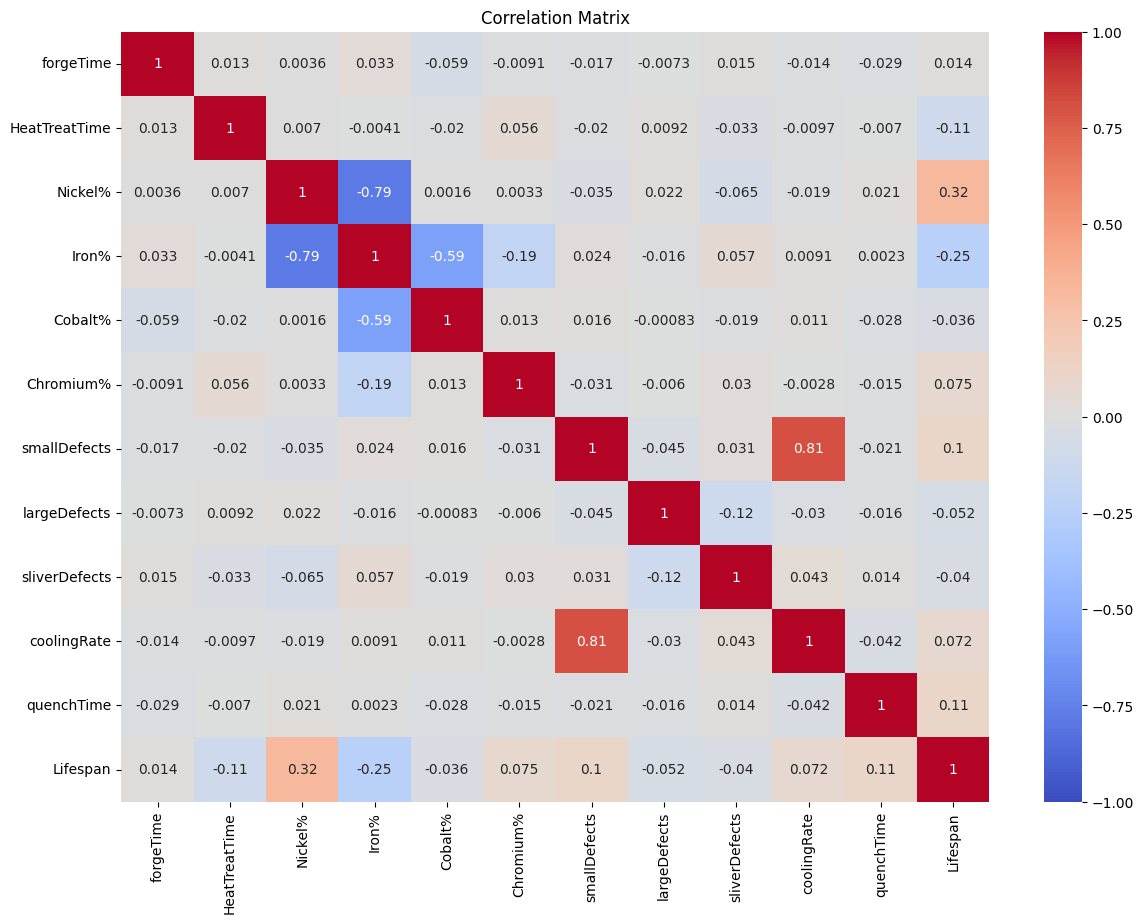

Strongly correlated features with Lifespan:
HeatTreatTime   -0.106178
Nickel%          0.321961
Iron%           -0.245234
smallDefects     0.103019
quenchTime       0.105064
Name: Lifespan, dtype: float64


In [105]:
# Correlation Analysis
plt.figure(figsize=(14, 10))  # Set the figure size
correlation_matrix = df[numerical_features].corr()  # Calculate the correlation matrix for numerical features
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)  # Plot the heatmap
plt.title('Correlation Matrix')  # Add the title
plt.show()

# Identify strongly correlated features with Lifespan (threshold: abs(correlation) > 0.1)
strong_correlations = correlation_matrix['Lifespan'][abs(correlation_matrix['Lifespan']) >= 0.1].drop('Lifespan')
print("Strongly correlated features with Lifespan:")  # Print the message
print(strong_correlations)  # Display the strongly correlated features

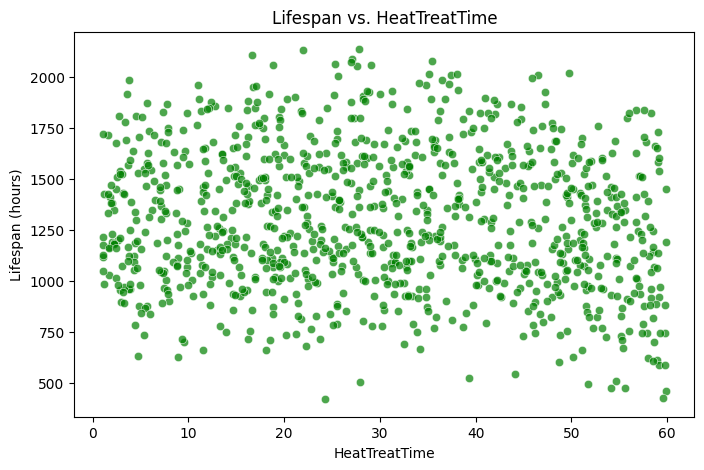

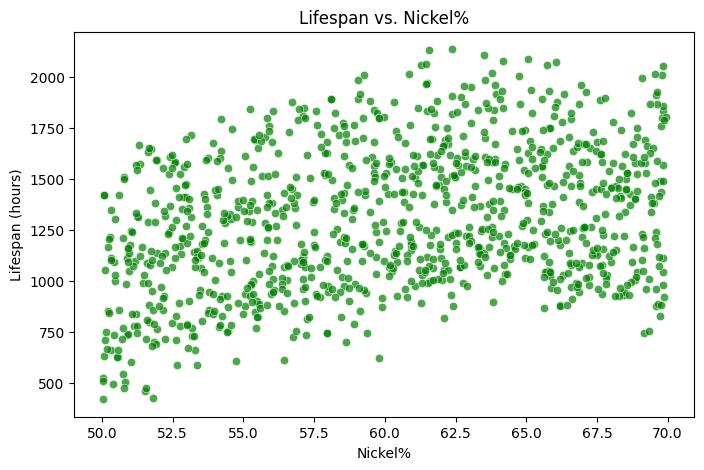

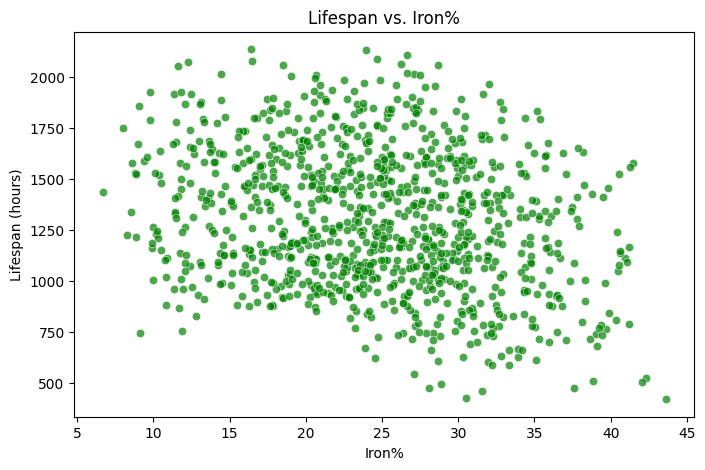

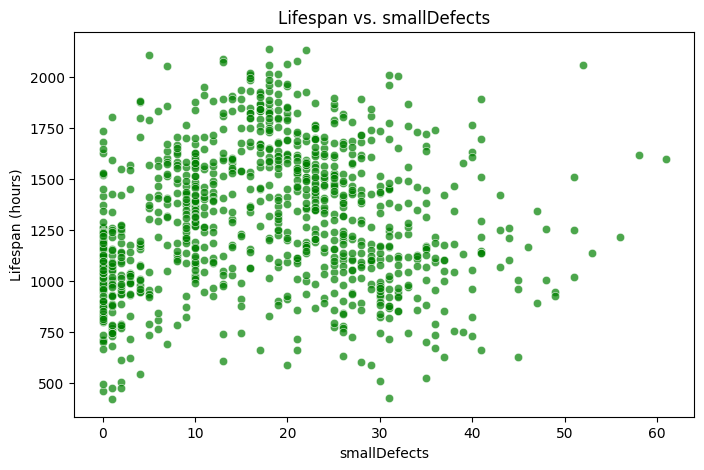

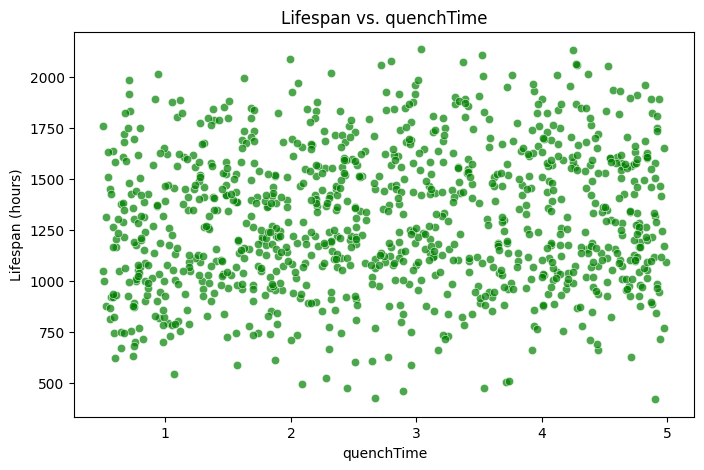

In [106]:
# Scatter plots for strongly correlated features
for feature in strong_correlations.index:
    plt.figure(figsize=(8, 5))  # Set the figure size
    sns.scatterplot(x=df[feature], y=df['Lifespan'], alpha=0.7, color='green')  # Plot scatter plot
    plt.title(f'Lifespan vs. {feature}')  # Add the title
    plt.xlabel(feature)  # Label the x-axis
    plt.ylabel('Lifespan (hours)')  # Label the y-axis
    plt.show()

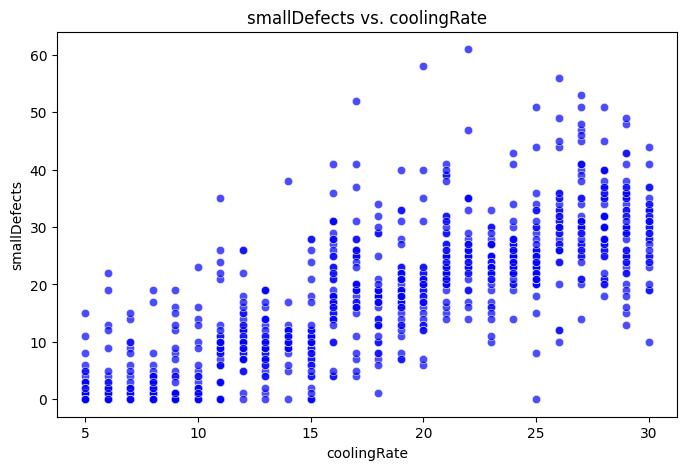

In [107]:
# Scatter plot for smallDefects vs. coolingRate
plt.figure(figsize=(8, 5))  # Set the figure size
sns.scatterplot(x=df['coolingRate'], y=df['smallDefects'], color='blue', alpha=0.7)  # Plot scatter plot
plt.title('smallDefects vs. coolingRate')  # Add the title
plt.xlabel('coolingRate')  # Label the x-axis
plt.ylabel('smallDefects')  # Label the y-axis
plt.show()

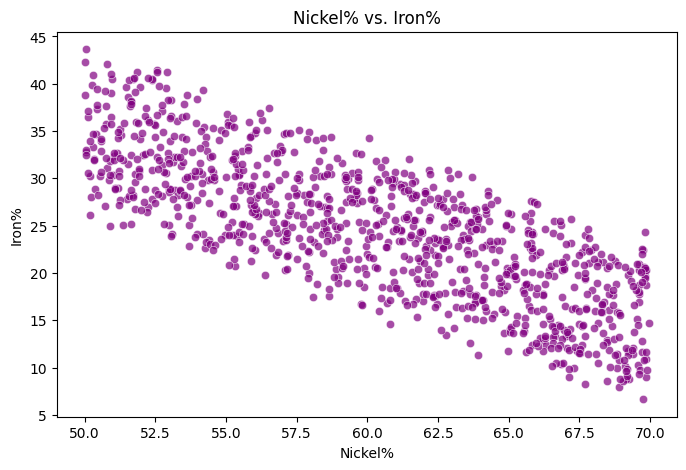

In [108]:
# Scatter plot for Nickel% vs. Iron% (Feature Interaction)
plt.figure(figsize=(8, 5))  # Set the figure size
sns.scatterplot(x=df['Nickel%'], y=df['Iron%'], color='purple', alpha=0.7)  # Plot scatter plot
plt.title('Nickel% vs. Iron%')  # Add the title
plt.xlabel('Nickel%')  # Label the x-axis
plt.ylabel('Iron%')  # Label the y-axis
plt.show()

In [109]:
# Define the target variable and features
X = df.drop('Lifespan', axis=1)  # Drop the target variable
y = df['Lifespan']  # Target variable

# Identify numerical and categorical features
numerical_features = ['forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'smallDefects',
                      'largeDefects', 'coolingRate']
categorical_features = ['partType', 'microstructure', 'castType']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ]
)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessing to the training and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print("Preprocessing completed successfully.")


Preprocessing completed successfully.


In [110]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train baseline Linear Regression
lr_baseline = LinearRegression()
lr_baseline.fit(X_train_preprocessed, y_train)
y_pred_lr = lr_baseline.predict(X_test_preprocessed)

# Train baseline XGBoost
xgb_baseline = XGBRegressor(random_state=42)
xgb_baseline.fit(X_train_preprocessed, y_train)
y_pred_xgb = xgb_baseline.predict(X_test_preprocessed)

# Evaluate baseline models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")

evaluate_model(y_test, y_pred_lr, "Linear Regression (Baseline)")
evaluate_model(y_test, y_pred_xgb, "XGBoost (Baseline)")

Linear Regression (Baseline) - MAE: 252.05, MSE: 92497.68, R2: 0.11
XGBoost (Baseline) - MAE: 59.88, MSE: 6149.63, R2: 0.94


In [111]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Linear Regression with Grid Search (Lasso or Ridge)
from sklearn.linear_model import Ridge
ridge = Ridge()
param_grid_lr = {'alpha': [0.1, 1, 10, 100]}  # Regularization strength
grid_search_lr = GridSearchCV(ridge, param_grid_lr, cv=5, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_train_preprocessed, y_train)

# XGBoost with Randomized Search
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
random_search_xgb = RandomizedSearchCV(
    XGBRegressor(random_state=42), param_distributions=param_grid_xgb,
    n_iter=50, cv=5, scoring='neg_mean_squared_error', random_state=42
)
random_search_xgb.fit(X_train_preprocessed, y_train)

# Evaluate best models from tuning
best_ridge = grid_search_lr.best_estimator_
best_xgb = random_search_xgb.best_estimator_

evaluate_model(y_test, best_ridge.predict(X_test_preprocessed), "Linear Regression (Tuned)")
evaluate_model(y_test, best_xgb.predict(X_test_preprocessed), "XGBoost (Tuned)")


Linear Regression (Tuned) - MAE: 251.25, MSE: 92167.73, R2: 0.11
XGBoost (Tuned) - MAE: 54.23, MSE: 4570.21, R2: 0.96


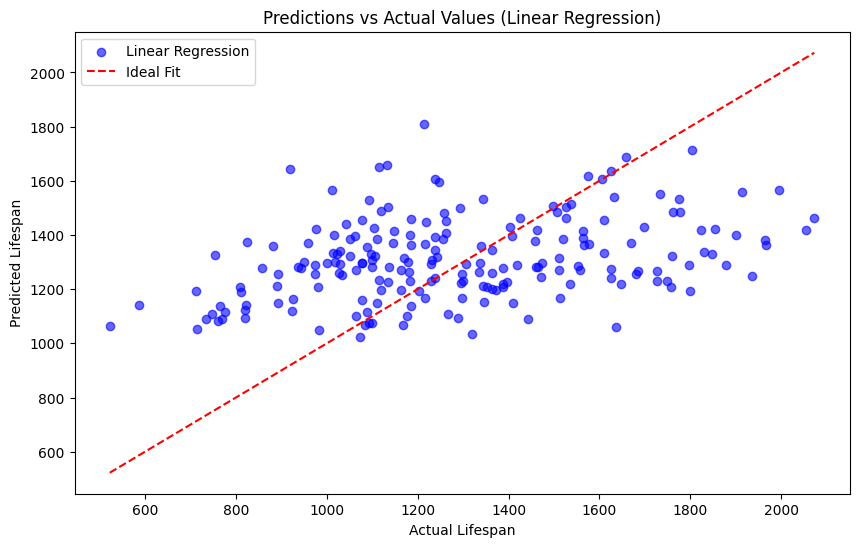

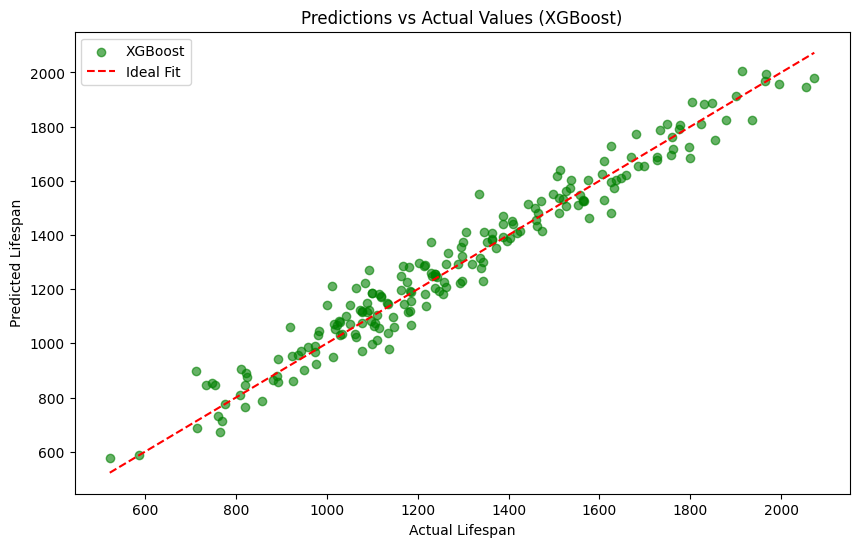

In [112]:
# Add Scatter Plots for Predictions vs Actual Values
# Scatter Plot: Predictions vs Actual Values for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr_tuned, alpha=0.6, color='blue', label="Linear Regression")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Ideal Fit")
plt.title("Predictions vs Actual Values (Linear Regression)")
plt.xlabel("Actual Lifespan")
plt.ylabel("Predicted Lifespan")
plt.legend()
plt.show()

# Scatter Plot: Predictions vs Actual Values for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb_tuned, alpha=0.6, color='green', label="XGBoost")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', label="Ideal Fit")
plt.title("Predictions vs Actual Values (XGBoost)")
plt.xlabel("Actual Lifespan")
plt.ylabel("Predicted Lifespan")
plt.legend()
plt.show()


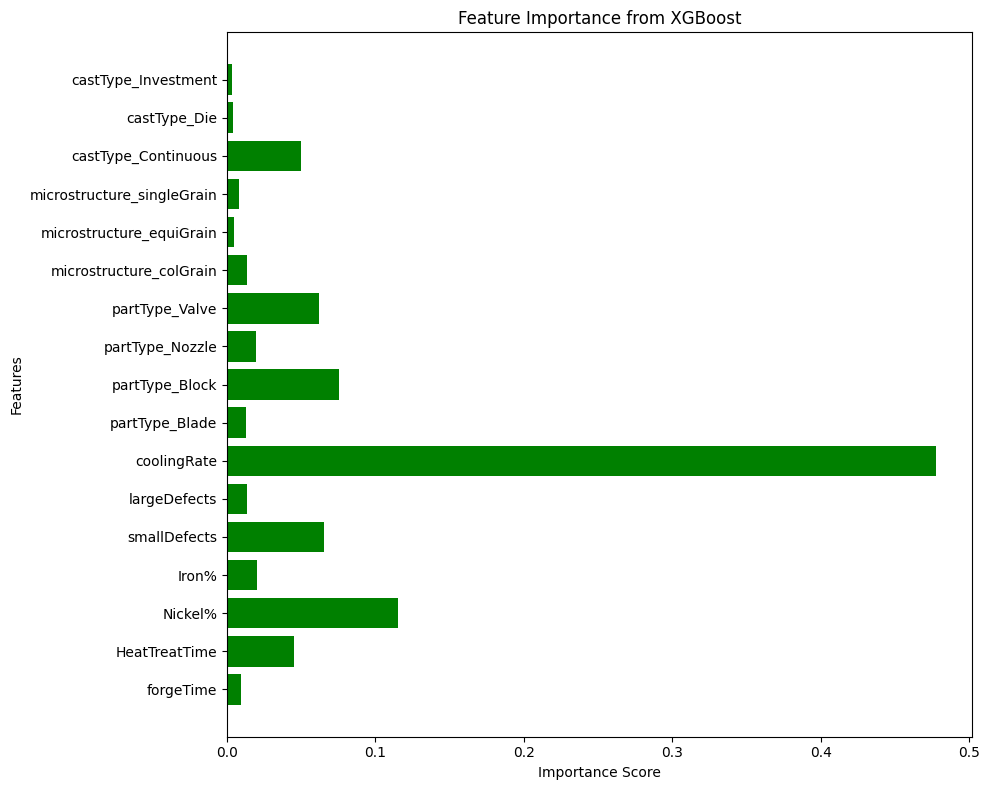

In [113]:
# Feature Importance Plot: XGBoost
xgb_importances = best_xgb.feature_importances_

# Retrieve feature names from preprocessor
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_names, xgb_importances, color='green')
plt.title("Feature Importance from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [114]:
# Create a new binary feature for whether the part meets the lifespan threshold
# A value of 1 indicates the part is not defective (Lifespan >= 1500 hours)
# A value of 0 indicates the part is defective (Lifespan < 1500 hours)

df['is_not_defective'] = (df['Lifespan'] >= 1500).astype(int)

# Display the first few rows to verify the new feature
print(df[['Lifespan', 'is_not_defective']].head())


   Lifespan  is_not_defective
0   1469.17                 0
1   1793.64                 1
2    700.60                 0
3   1082.10                 0
4   1838.83                 1


In [115]:
from sklearn.cluster import KMeans
import numpy as np

# Select relevant features for clustering
clustering_features = ['Lifespan', 'Nickel%', 'Iron%', 'smallDefects', 'largeDefects', 'coolingRate']

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clustering_data = scaler.fit_transform(df[clustering_features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df['cluster_group'] = kmeans.fit_predict(clustering_data)

# Display the cluster assignments
print(df[['Lifespan', 'cluster_group']].head())


   Lifespan  cluster_group
0   1469.17              3
1   1793.64              0
2    700.60              4
3   1082.10              1
4   1838.83              0


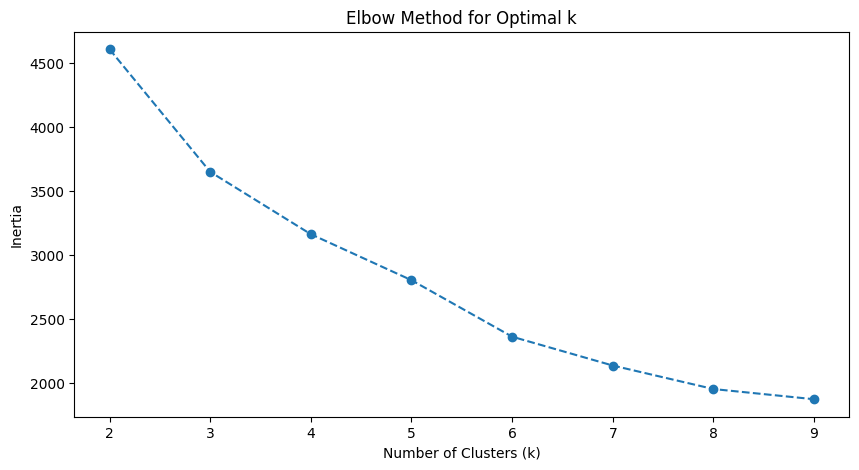

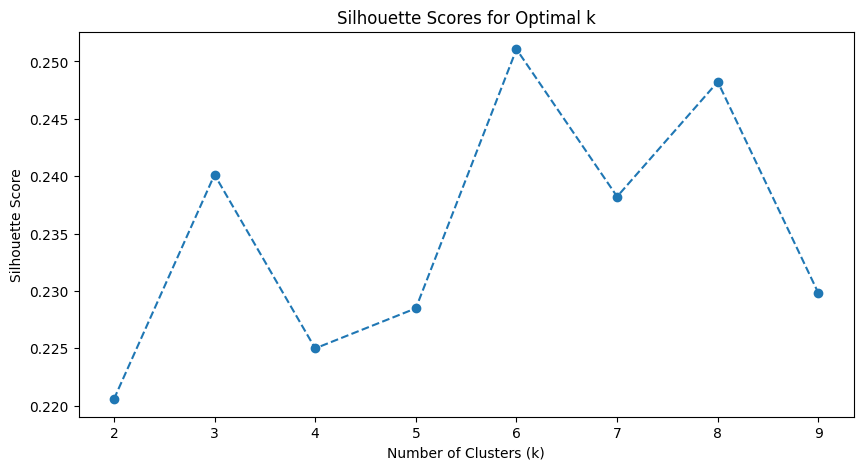

In [116]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Determine optimal number of clusters using the Elbow Method and Silhouette Score
elbow_inertia = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(clustering_data)
    elbow_inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(clustering_data, cluster_labels))
# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(k_values, elbow_inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')  # Use silhouette_k_values
plt.title('Silhouette Scores for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

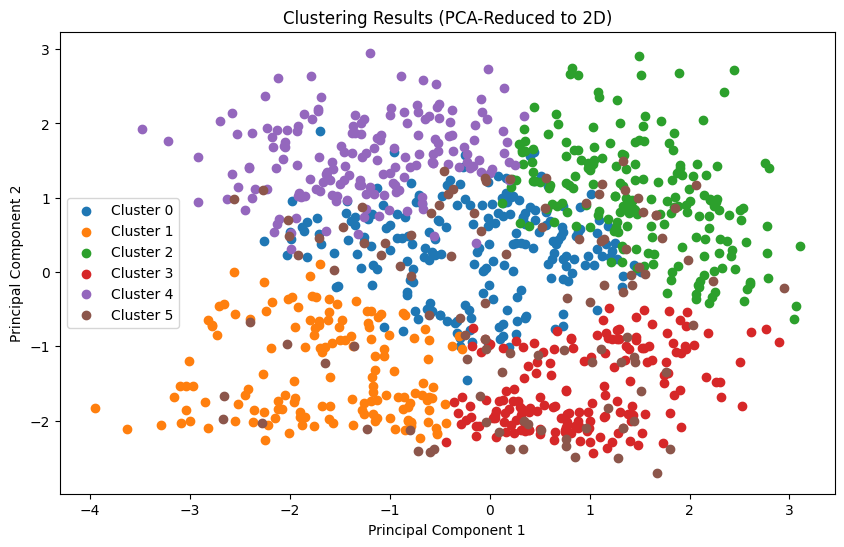

In [117]:
from sklearn.decomposition import PCA
import numpy as np

# Reduce the feature space to 2D using PCA
pca = PCA(n_components=2)
clustering_data_2d = pca.fit_transform(clustering_data)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
for cluster in np.unique(df['cluster_group']):
    plt.scatter(
        clustering_data_2d[df['cluster_group'] == cluster, 0],
        clustering_data_2d[df['cluster_group'] == cluster, 1],
        label=f'Cluster {cluster}'
    )

plt.title('Clustering Results (PCA-Reduced to 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Define target and features
X = df.drop(['Lifespan', 'is_not_defective'], axis=1)
y = df['is_not_defective']

# Define numerical and categorical features
numerical_features = ['forgeTime', 'HeatTreatTime', 'Nickel%', 'Iron%', 'smallDefects',
                      'largeDefects', 'coolingRate']
categorical_features = ['partType', 'microstructure', 'castType']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# SMOTE for class balancing
smote = SMOTE(random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define pipelines for Random Forest and Logistic Regression
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(random_state=42))
])

logreg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Fit baseline models
rf_pipeline.fit(X_train, y_train)
logreg_pipeline.fit(X_train, y_train)

# Evaluate baseline models
def evaluate_classifier(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

evaluate_classifier(rf_pipeline, X_test, y_test, "Random Forest (Baseline)")
evaluate_classifier(logreg_pipeline, X_test, y_test, "Logistic Regression (Baseline)")



Random Forest (Baseline) Results:
Accuracy: 0.885

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       139
           1       0.82      0.80      0.81        61

    accuracy                           0.89       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.88      0.89      0.88       200


Confusion Matrix:
[[128  11]
 [ 12  49]]

Logistic Regression (Baseline) Results:
Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       139
           1       0.48      0.52      0.50        61

    accuracy                           0.68       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.69      0.68      0.68       200


Confusion Matrix:
[[104  35]
 [ 29  32]]


Class distribution before SMOTE: Counter({0: 555, 1: 245})
Class distribution after SMOTE: Counter({0: 555, 1: 555})


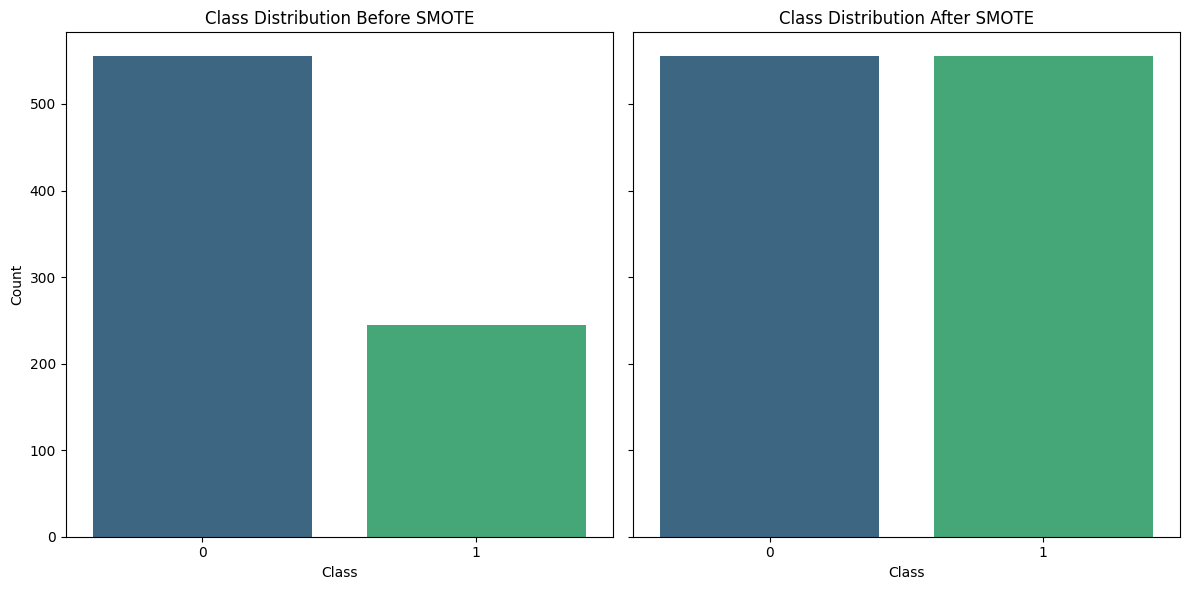

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE

# Check class distribution before SMOTE
counter_before = Counter(y_train)
print("Class distribution before SMOTE:", counter_before)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train)

# Check class distribution after SMOTE
counter_after = Counter(y_train_balanced)
print("Class distribution after SMOTE:", counter_after)

# Plot class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Before SMOTE
sns.barplot(x=list(counter_before.keys()), y=list(counter_before.values()), ax=axes[0], palette="viridis")
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# After SMOTE
sns.barplot(x=list(counter_after.keys()), y=list(counter_after.values()), ax=axes[1], palette="viridis")
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Class")

plt.tight_layout()
plt.show()


In [120]:
# Random Forest Hyperparameter Tuning
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200, 300, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced','balanced_subsample']
}

rf_search = RandomizedSearchCV(
    rf_pipeline, param_distributions=rf_param_grid, n_iter=100,
    scoring='f1', cv=5, random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_search.best_params_)
print("Best F1-Score for Random Forest:", rf_search.best_score_)

# Logistic Regression Hyperparameter Tuning
logreg_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver': ['liblinear', 'saga']
}

logreg_search = RandomizedSearchCV(
    logreg_pipeline, param_distributions=logreg_param_grid, n_iter=50,
    scoring='f1', cv=5, random_state=42, n_jobs=-1
)
logreg_search.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", logreg_search.best_params_)
print("Best F1-Score for Logistic Regression:", logreg_search.best_score_)


Best Random Forest Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20, 'classifier__class_weight': 'balanced_subsample'}
Best F1-Score for Random Forest: 0.8378258286186675
Best Logistic Regression Parameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 0.1}
Best F1-Score for Logistic Regression: 0.5154275757720261


In [121]:
# Final Evaluation of the Tuned Random Forest Classifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on the test set using the best Random Forest model
y_pred_rf_final = rf_search.best_estimator_.predict(X_test)

# Evaluate the performance of the Random Forest model
print("Final Evaluation of Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_final))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_final))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_final))


Final Evaluation of Random Forest Classifier:
Accuracy: 0.9

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       139
           1       0.83      0.85      0.84        61

    accuracy                           0.90       200
   macro avg       0.88      0.89      0.88       200
weighted avg       0.90      0.90      0.90       200


Confusion Matrix:
[[128  11]
 [  9  52]]


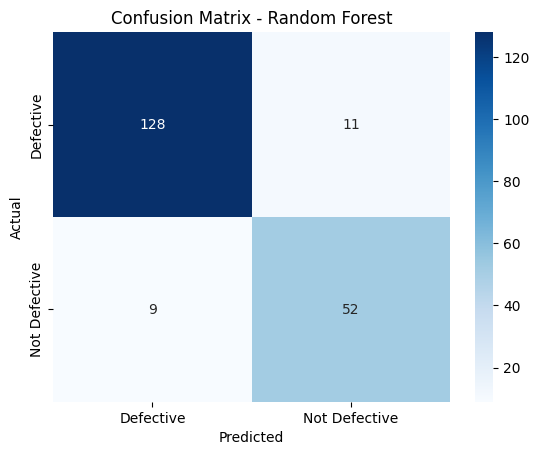

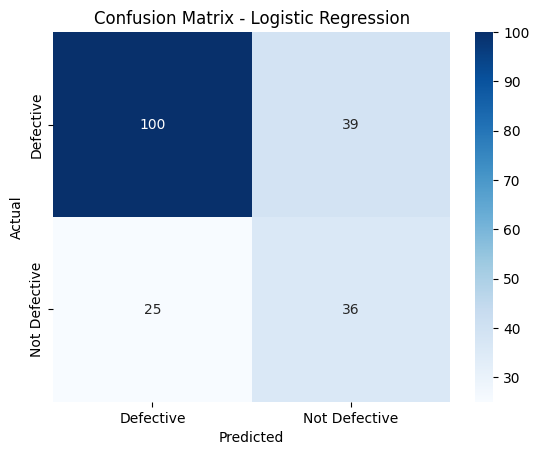

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf_final)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['Defective', 'Not Defective'], yticklabels=['Defective', 'Not Defective'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for Logistic Regression
y_pred_logreg_final = logreg_search.best_estimator_.predict(X_test)
cm_logreg = confusion_matrix(y_test, y_pred_logreg_final)
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=['Defective', 'Not Defective'], yticklabels=['Defective', 'Not Defective'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
